In [1]:
import tensorflow as tf 
import keras
import numpy as np
import pandas as pd
import seaborn as sns

seed=222
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten 
from keras.layers import MaxPooling2D, Dropout

from skimage import io
import matplotlib.pyplot as plt

import os

from keras_preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

Using TensorFlow backend.


In [2]:
df = pd.read_csv("fashion-dataset/styles.csv", usecols = [0,1,2,3,4,5,6,7,8,9])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
id                    44446 non-null int64
gender                44446 non-null object
masterCategory        44446 non-null object
subCategory           44446 non-null object
articleType           44446 non-null object
baseColour            44431 non-null object
season                44425 non-null object
year                  44445 non-null float64
usage                 44129 non-null object
productDisplayName    44439 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [3]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


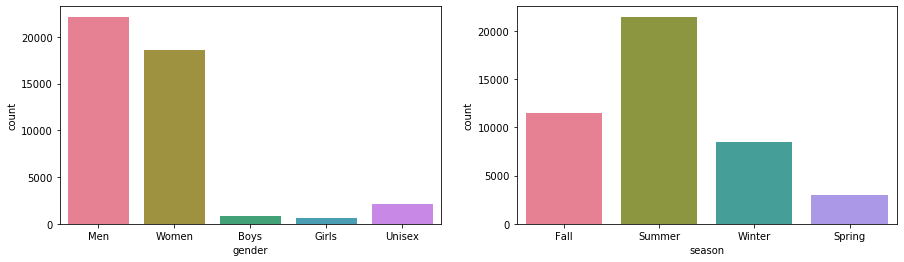

In [4]:
f, axes = plt.subplots(1, 2, figsize=(15,4)) 

sns.countplot(x="gender", data=df, ax=axes[0], palette = "husl")
sns.countplot(x="season", data=df, ax=axes[1], palette = "husl")

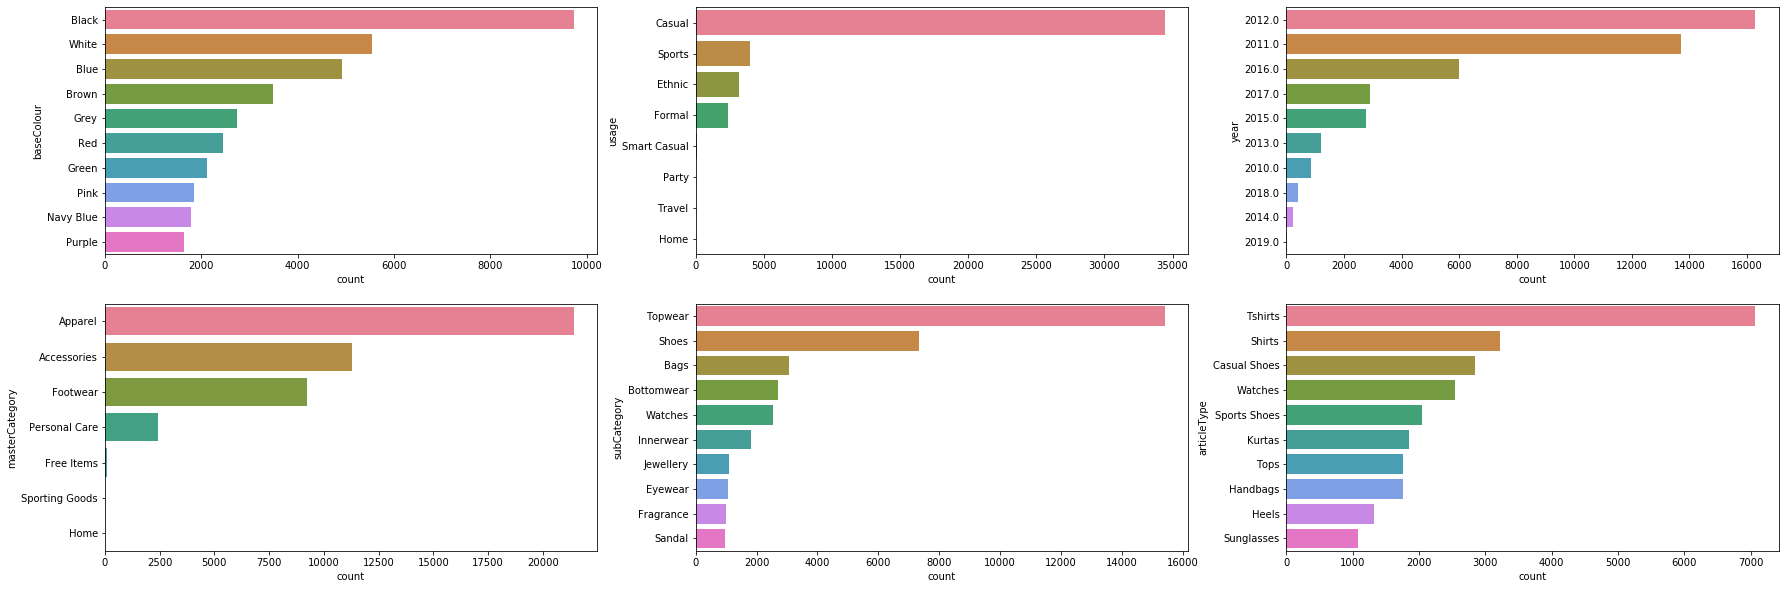

In [5]:
f, axes = plt.subplots(2, 3, figsize=(30,10)) 
sns.countplot(y="baseColour", data=df, ax=axes[0,0], order=df.baseColour.value_counts().iloc[:10].index, palette = "husl")
sns.countplot(y="usage", data=df, ax=axes[0,1], order=df.usage.value_counts().iloc[:10].index, palette = "husl")
sns.countplot(y="year", data=df, ax=axes[0,2], order=df.year.value_counts().iloc[:10].index, palette = "husl")

sns.countplot(y="masterCategory", data=df, ax=axes[1,0], order=df.masterCategory.value_counts().iloc[:10].index, palette = "husl")
sns.countplot(y="subCategory", data=df, ax=axes[1,1], order=df.subCategory.value_counts().iloc[:10].index, palette = "husl")
sns.countplot(y="articleType", data=df, ax=axes[1,2],order=df.articleType.value_counts().iloc[:10].index, palette = "husl")

In [6]:
# targets = ['Topwear','Shoes','Bags','Bottomwear','Watches']
# df = df[df['subCategory'].isin(targets)]
# df['subCategory'].value_counts()
targets = [ "Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses", "Backpacks", "Jeans", "Shorts"]
df = df[df['articleType'].isin(targets)]
df['articleType'].value_counts()

Shirts          3217
Watches         2542
Sports Shoes    2036
Tops            1762
Handbags        1759
Heels           1323
Sunglasses      1073
Backpacks        724
Jeans            609
Shorts           547
Name: articleType, dtype: int64

In [7]:
large = ["Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses"]
small = ["Backpacks", "Jeans", "Shorts"]

In [8]:
lst = []
for t in targets:
    temp = df[df['articleType'] == t]
    if t in small:
        lst.append(temp)
    else:
        lst.append(temp.sample(n = 1000, random_state = seed))
mydf = pd.concat(lst)

In [9]:
mydf['articleType'].value_counts()

Handbags        1000
Shirts          1000
Sunglasses      1000
Tops            1000
Heels           1000
Sports Shoes    1000
Watches         1000
Backpacks        724
Jeans            609
Shorts           547
Name: articleType, dtype: int64

In [10]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8880 entries, 42175 to 44422
Data columns (total 10 columns):
id                    8880 non-null int64
gender                8880 non-null object
masterCategory        8880 non-null object
subCategory           8880 non-null object
articleType           8880 non-null object
baseColour            8874 non-null object
season                8872 non-null object
year                  8880 non-null float64
usage                 8879 non-null object
productDisplayName    8880 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 763.1+ KB


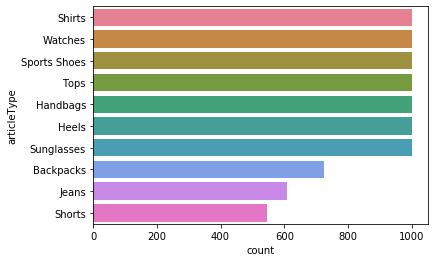

In [11]:
sns.countplot(y="articleType", data=mydf, palette = "husl")

In [12]:
mydf.to_csv("datasets/mystyle.csv", index = False)

In [13]:
train_df = mydf[['articleType', 'id']].sample(frac=0.8,random_state = seed) 
test_df = mydf[['articleType', 'id']].drop(train_df.index)

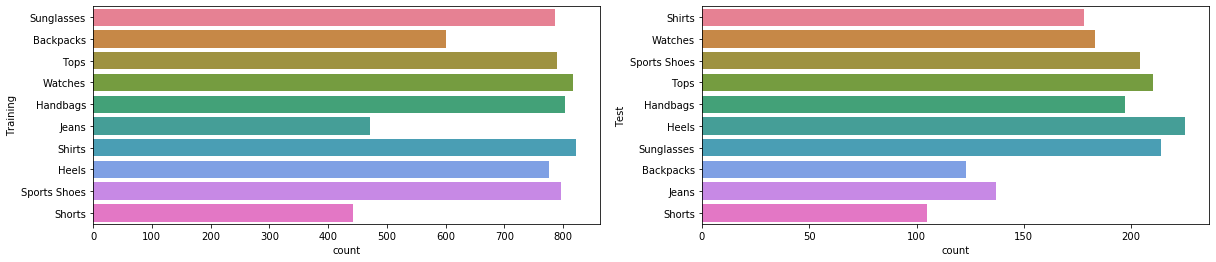

In [14]:
f, axes = plt.subplots(1, 2, figsize=(20,4)) 
sns.countplot(y="articleType", data=train_df, ax=axes[0], palette = "husl").set(ylabel='Training');
sns.countplot(y="articleType", data=test_df, ax=axes[1], palette = "husl").set(ylabel='Test');

In [15]:
test_df.head(10)

,articleType,id
1136,Shirts,11378
5866,Shirts,11052
2598,Shirts,33247
15608,Shirts,8829
23300,Shirts,11113
10353,Shirts,13768
5682,Shirts,18319
37765,Shirts,37724
3325,Shirts,9805
34817,Shirts,20139


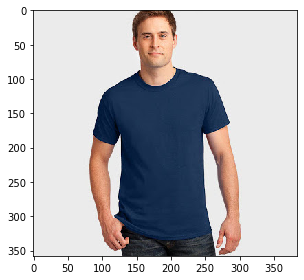

In [16]:
img_id = 11378
path = "fashion-dataset/images/{}.jpg".format(img_id)
path = "fashion-dataset/sample.jpg"
img1 = io.imread(path)
io.imshow(img1)

In [17]:
from skimage import filters
from skimage import morphology
# https://stackoverflow.com/questions/63001988/how-to-remove-background-of-images-in-python
# https://stackoverflow.com/questions/60033008/remove-image-background-and-extract-the-object-in-image
# https://towardsdatascience.com/dress-segmentation-with-autoencoder-in-keras-497cf1fd169a

In [17]:
IMAGE_SHAPE = img1.shape
IMAGE_SHAPE

(358, 384, 3)

yes


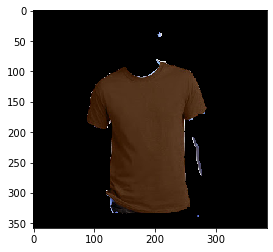

In [18]:
# https://github.com/ncaadam/clothing_segmentation/blob/master/clothing_segmentation_api.py

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html
# import json
# import os
# import time

# import API packages
# from tornado.ioloop import IOLoop
# import tornado.web
# from tornado import gen
# import concurrent
# from concurrent.futures import ThreadPoolExecutor
# from tornado.concurrent import run_on_executor
# from tornado.httpclient import AsyncHTTPClient
# from tornado.web import url
#import tornado.ioloop

# import opencv and numpy
import cv2
import numpy as np


def canny_grab(image):
	"""
	Run Canny Edge Detection on input image and find the bounding box that surrounds the edges
	input - cv2 Image
	output - grayscale mask for the edges, the top left corner of the bounding box, and the bottom right of the bounding box
	"""
	canny_out = cv2.Canny(image,0,image.flatten().mean())
	y,x = canny_out.nonzero()
	top_left = x.min(), y.min()
	bot_right = x.max(), y.max()
	return canny_out, top_left, bot_right


def grab_cut(image, top_left, bot_right):
	"""
	Utililize openCv's foreground detection algorithm
	input - cv2 image, top left and bottom right of a bounding box to focus on
	output - cv2 image of the estimated foreground
	"""
	mask = np.zeros(image.shape[:2],np.uint8)
	background = np.zeros((1,65),np.float64)
	foreground = np.zeros((1,65),np.float64)
	roi = (top_left[0],top_left[1],bot_right[0],bot_right[1])
	cv2.grabCut(image, mask, roi, background, foreground, 5, cv2.GC_INIT_WITH_RECT)
	new_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
	image = image*new_mask[:,:,np.newaxis]
	return image


def bg_removal(orig, grabbed):
	"""
	Remove additional background pixels after the initial grabcut
	input - cv2 image (the original image before the grabcut), the image after the grabcut
	output - a grayscale mask of background pixels
	"""
	kernel = np.ones((3,3),np.uint8)
	mean,std = cv2.meanStdDev(cv2.cvtColor(orig,cv2.COLOR_BGR2HLS), cv2.inRange(grabbed,0,0))
	min_thresh = mean - std
	max_thresh = mean + std
	grab_bg = cv2.inRange(cv2.cvtColor(grabbed,cv2.COLOR_BGR2HLS),min_thresh,max_thresh)
	dilated_bg = cv2.morphologyEx(grab_bg, cv2.MORPH_OPEN, kernel)
	return dilated_bg


def watershed(grabbed):
	"""
	Run the watershed algorithm to try and find connected components
	input - cv2 image
	output - cv2 image with the marked connected components
	"""
	gray = cv2.cvtColor(grabbed,cv2.COLOR_BGR2GRAY)
	_, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

	kernel = np.ones((3,3),np.uint8)
	opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=3)

	background = cv2.dilate(opening, kernel, iterations=2)

	dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
	_, foreground = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255, 0)

	foreground = np.uint8(foreground) 
	unknown = cv2.subtract(background,foreground)

	_, ccs = cv2.connectedComponents(foreground)
	ccs = ccs + 1
	ccs[unknown==255] = 0
	ccs = cv2.watershed(grabbed,ccs)
	return ccs


def get_skin_hair_mean_std(image, K = 2):
	"""
	Identify the skin pixel mean and standard deviation from a face image using Kmeans
	
	input - cv2 image of a human face, the number of clusters (K) for the Kmeans to reduce down to
	output - 
	"""
	data = image.reshape((-1,3))
	data = np.float32(data)

	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
	K = K

	ret,label,center=cv2.kmeans(data, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

	center = np.uint8(center)
	result = center[label.flatten()]
	result_2 = result.reshape((image.shape))

	one_count = np.sum(label)
	zero_count = label.size - one_count

	skin_label = 1 if one_count > zero_count else 0
	hair_label = 1 - skin_label

	skin_BGR = center[skin_label]
	hair_BGR = center[hair_label]
	skin_mean,skin_std = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV), mask = cv2.inRange(result_2,skin_BGR,skin_BGR))
	hair_mean,hair_std = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV), mask = cv2.inRange(result_2,hair_BGR,hair_BGR))

	return skin_mean, skin_std, hair_mean, hair_std


def subtract_skin(orig, face):
	"""
	Subtract the skin from an image given a facial crop
	
	input - cv2 image
	output - a grayscale mask of the skin in the image
	""" 
	skin_mean, skin_std, _, _ = get_skin_hair_mean_std(face,2)
	kernel = np.ones((3,3),np.uint8)
	min_thresh = skin_mean - (skin_std*2)
	max_thresh = skin_mean + (skin_std*2)
	min_thresh[2] = 0
	max_thresh[2] = 255
	grab_skin = cv2.inRange(cv2.cvtColor(orig,cv2.COLOR_BGR2HSV),min_thresh,max_thresh)
	dilated_skin = cv2.morphologyEx(grab_skin, cv2.MORPH_OPEN, kernel)
	return dilated_skin


def subtract_hair(orig, face): 
	"""
	Subtract the hair from an image given a facial crop
	input - cv2 image
	output - a grayscale mask of the hair in the image
	""" 
	_, _, hair_mean, hair_std = get_skin_hair_mean_std(face,2)
	kernel = np.ones((3,3),np.uint8)
	min_thresh = hair_mean - (hair_std*2)
	max_thresh = hair_mean + (hair_std*2)
	grab_hair = cv2.inRange(cv2.cvtColor(orig,cv2.COLOR_BGR2HSV),min_thresh,max_thresh)
	dilated_hair = cv2.morphologyEx(grab_hair, cv2.MORPH_OPEN, kernel)
	return dilated_hair


def find_face(image):
	"""
	Subtract the skin from an image
	input - cv2 image
	output - a grayscale image of the face
	""" 
	img2 = image.copy()
	gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
	face_cascade = cv2.CascadeClassifier('/Users/zihe/anaconda3/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml')
	faces = face_cascade.detectMultiScale(gray, 1.1, 5)

	the_face = None

	if len(faces) > 0:
	    face_imgs = list()
	    for (x,y,w,h) in faces:
	        face_imgs.append(img2[y:y+h, x:x+w])

	    face_sizes = np.array([face.size for face in face_imgs])
	    the_face = face_imgs[face_sizes.argmax()]

	return the_face


# load image
img = cv2.imread(path)
# run canny edge detection
canny_img, tl, br = canny_grab(img)
roi = img[tl[1]:br[1], tl[0]:br[0]]

i = 0
the_face = None
#the face isn't always found on the first iteration, so we search 5 times
while (the_face is None) and (i < 5):
    i += 1
    grab = grab_cut(img, tl, br)
    the_face = find_face(grab)

# remove any left over background in the image
bg_mask = bg_removal(img, grab)
bg_removed = cv2.subtract(grab, cv2.cvtColor(bg_mask,cv2.COLOR_GRAY2BGR))

# if there is a face, we subtract the skin and the hair
if the_face is not None:
    print('yes')
    subtracted_skin_mask = subtract_skin(grab,the_face)
    subtracted_hair_mask = subtract_hair(grab,the_face)
    skin_removed = cv2.subtract(bg_removed, cv2.cvtColor(subtracted_skin_mask,cv2.COLOR_GRAY2BGR))
    hair_removed = cv2.subtract(skin_removed, cv2.cvtColor(subtracted_hair_mask,cv2.COLOR_GRAY2BGR))
    grab = hair_removed.copy()
else: # could be improved by using kmeans to try and identify the skin when a face isn't found
    grab = bg_removed.copy()

# run the watershed algorithm to find connected components
grab = cv2.GaussianBlur(grab, (15,15),0)
watershed_out = watershed(grab)

# subtract everything out but the foreground watershed piece 
final_piece = cv2.bitwise_and(img, cv2.cvtColor(cv2.inRange(watershed_out,1,1),cv2.COLOR_GRAY2BGR))


plt.imshow(final_piece)

In [19]:
cv2.imwrite("result.png", final_piece)

True

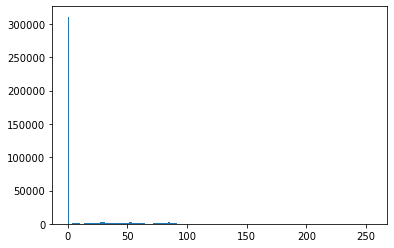

In [20]:
ax = plt.hist(final_piece.ravel() , bins = 256)
plt.show()

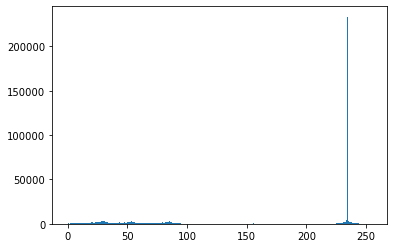

In [21]:
ax = plt.hist(img1.ravel() , bins = 256)
plt.show()

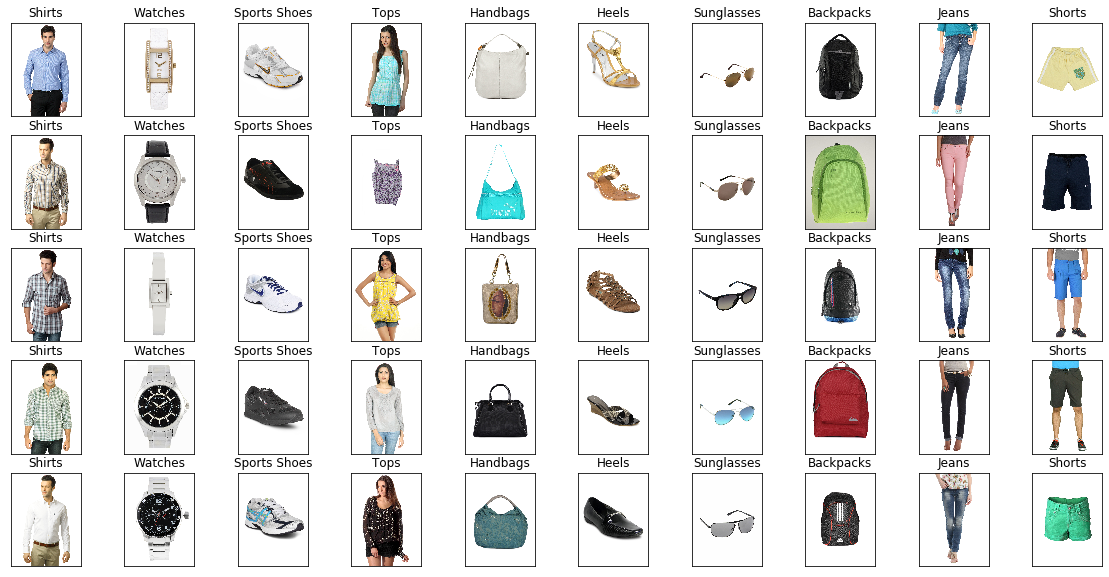

In [118]:
%matplotlib inline 

fig, axarr = plt.subplots(nrows=5, ncols=10, figsize=(20,10))

for i, cat in enumerate(targets):
    for j, img_id in enumerate(train_df[train_df["articleType"] == cat]['id'][:5]):
        path = "fashion-dataset/images/{}.jpg".format(img_id)
        img = io.imread(path)
        axarr[j,i].imshow(img)
        axarr[j,i].set_xticks([])
        axarr[j,i].set_yticks([])
        axarr[j,i].set_title("{}".format(cat))
# plt.suptitle("Figure 1: There are 40 distinct people in the dataset, 10 images for each people.")

In [46]:
DATASET_PATH = "datasets/images/"
# print(os.listdir(DATASET_PATH))

In [47]:
# df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000, error_bad_lines=False)
train_df['image'] = train_df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
train_df = train_df.sample(frac=1).reset_index(drop=True)

test_df['image'] = test_df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [48]:
batch_size = 32

image_generator = ImageDataGenerator(
    validation_split=0.2
)

training_generator = image_generator.flow_from_dataframe(
    # https://keras.io/api/preprocessing/image/ 
    dataframe=train_df,
    directory=DATASET_PATH,
    x_col="image",
    y_col="articleType",
    target_size=(80,60), #image_size？ 
    batch_size=batch_size,
    subset="training",
#     class_mode="categorical",
    seed=seed,
    shuffle=True
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=DATASET_PATH,
    x_col="image",
    y_col="articleType",
    target_size=(80,60),
    batch_size=batch_size,
    subset="validation",
#     class_mode="categorical",
    seed=seed,
    shuffle=True
)

classes = training_generator.class_indices

test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=DATASET_PATH,
    x_col="image",
    y_col="articleType",
    batch_size=batch_size,
    seed=110,
    shuffle=seed,
#     class_mode=None,
    target_size=(80,60)
)

/Users/zihe/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5683 validated image filenames belonging to 10 classes.
Found 1420 validated image filenames belonging to 10 classes.
Found 1775 validated image filenames belonging to 10 classes.


In [49]:
classes

{'Backpacks': 0,
 'Handbags': 1,
 'Heels': 2,
 'Jeans': 3,
 'Shirts': 4,
 'Shorts': 5,
 'Sports Shoes': 6,
 'Sunglasses': 7,
 'Tops': 8,
 'Watches': 9}

In [50]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))
# optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 76, 56, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 13056)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              13057000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)             

In [51]:
from math import ceil

hist = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=ceil(0.8 * (train_df.size / batch_size)),

    validation_data=validation_generator,
    validation_steps=ceil(0.2 * (train_df.size / batch_size)),

    epochs=10,
#     verbose=1
)

Epoch 1/10
533/533 [==============================] - 128s 241ms/step - loss: 3.4679 - accuracy: 0.6108 - val_loss: 0.5807 - val_accuracy: 0.8616
Epoch 2/10
533/533 [==============================] - 131s 247ms/step - loss: 0.3751 - accuracy: 0.8868 - val_loss: 0.3426 - val_accuracy: 0.9184
Epoch 3/10
533/533 [==============================] - 132s 247ms/step - loss: 0.1485 - accuracy: 0.9529 - val_loss: 0.8093 - val_accuracy: 0.9123
Epoch 4/10
533/533 [==============================] - 132s 248ms/step - loss: 0.0951 - accuracy: 0.9679 - val_loss: 0.2541 - val_accuracy: 0.9094
Epoch 5/10
533/533 [==============================] - 133s 250ms/step - loss: 0.6878 - accuracy: 0.7611 - val_loss: 2.2722 - val_accuracy: 0.1105
Epoch 6/10
533/533 [==============================] - 133s 250ms/step - loss: 1.9649 - accuracy: 0.3037 - val_loss: 1.6051 - val_accuracy: 0.4652
Epoch 7/10
533/533 [==============================] - 134s 252ms/step - loss: 2.0637 - accuracy: 0.2846 - val_loss: 2.2770 -

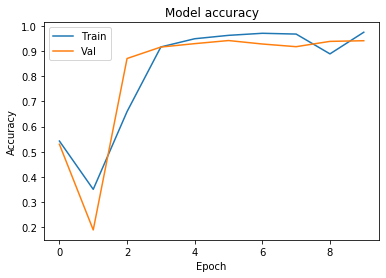

In [24]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

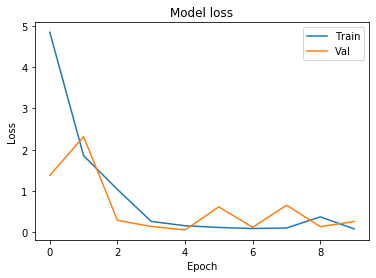

In [25]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [52]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
score = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.115410327911377
Test accuracy: 0.1818181872367859


In [50]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()

pred = model.predict_generator(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

7/7 [==============================] - 2s 318ms/step


In [51]:
pred

array([[4.4928202e-06, 1.4128682e-05, 1.9776453e-06, 9.9997938e-01,
        6.0717311e-09],
       [1.7207154e-22, 2.1647384e-25, 3.4528249e-23, 2.0566543e-23,
        1.0000000e+00],
       [1.4138406e-11, 2.9674808e-11, 3.8009926e-15, 1.0000000e+00,
        1.1403023e-13],
       ...,
       [5.0361890e-15, 7.8384420e-15, 1.0000000e+00, 4.8934371e-14,
        1.7360309e-15],
       [8.0330538e-15, 6.2175348e-15, 2.4907451e-16, 1.0000000e+00,
        9.1359686e-15],
       [1.3005118e-12, 1.4934277e-14, 1.0000000e+00, 2.3574561e-13,
        7.0431022e-16]], dtype=float32)

In [52]:
predicted_class_indices = np.argmax(pred, axis=1)
predicted_class_indices

array([3, 4, 3, 3, 1, 0, 0, 0, 4, 0, 0, 2, 3, 2, 3, 2, 4, 0, 4, 2, 4, 2,
       2, 2, 2, 0, 3, 1, 0, 0, 3, 2, 1, 4, 4, 3, 0, 2, 0, 1, 1, 2, 1, 1,
       2, 1, 4, 3, 2, 2, 2, 3, 1, 4, 3, 3, 1, 4, 3, 3, 4, 3, 2, 0, 4, 2,
       1, 4, 0, 0, 1, 1, 1, 4, 0, 3, 3, 3, 4, 4, 1, 2, 0, 2, 4, 3, 3, 0,
       3, 0, 2, 1, 4, 4, 4, 3, 4, 1, 4, 4, 3, 0, 1, 2, 0, 0, 4, 0, 0, 0,
       1, 0, 2, 3, 1, 2, 1, 1, 0, 4, 1, 1, 2, 4, 4, 4, 2, 2, 0, 1, 3, 3,
       4, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 4, 1, 4, 2, 1, 3, 3, 4, 4, 3, 3,
       4, 0, 4, 2, 3, 3, 1, 0, 4, 2, 2, 0, 2, 0, 1, 0, 1, 4, 1, 4, 4, 4,
       1, 0, 3, 0, 3, 1, 0, 2, 4, 1, 3, 4, 4, 4, 3, 0, 3, 2, 0, 0, 4, 1,
       4, 1, 0, 0, 3, 4, 2, 1, 2, 2, 2, 1, 3, 3, 0, 1, 2, 1, 4, 3, 4, 1,
       0, 2, 3, 2])

In [56]:
labels = (training_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions[:3]

['Topwear', 'Watches', 'Topwear']

In [55]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
# results.to_csv("results.csv",index=False)

['5446.jpg',
 '25335.jpg',
 '32385.jpg',
 '3745.jpg',
 '58560.jpg',
 '47128.jpg',
 '38441.jpg',
 '53979.jpg',
 '11138.jpg',
 '37409.jpg',
 '10213.jpg',
 '25564.jpg',
 '40138.jpg',
 '35705.jpg',
 '4309.jpg',
 '4558.jpg',
 '25332.jpg',
 '27668.jpg',
 '33895.jpg',
 '36142.jpg',
 '40552.jpg',
 '34849.jpg',
 '31960.jpg',
 '7576.jpg',
 '38674.jpg',
 '54393.jpg',
 '10683.jpg',
 '23455.jpg',
 '54507.jpg',
 '14812.jpg',
 '52052.jpg',
 '4336.jpg',
 '7179.jpg',
 '50392.jpg',
 '45020.jpg',
 '13496.jpg',
 '14815.jpg',
 '22914.jpg',
 '34885.jpg',
 '37202.jpg',
 '50950.jpg',
 '4551.jpg',
 '31334.jpg',
 '13260.jpg',
 '41822.jpg',
 '30411.jpg',
 '46463.jpg',
 '9885.jpg',
 '24473.jpg',
 '26588.jpg',
 '8966.jpg',
 '27657.jpg',
 '16511.jpg',
 '45224.jpg',
 '30614.jpg',
 '1811.jpg',
 '54792.jpg',
 '46499.jpg',
 '2836.jpg',
 '5210.jpg',
 '59218.jpg',
 '16913.jpg',
 '5479.jpg',
 '39936.jpg',
 '50395.jpg',
 '32188.jpg',
 '28817.jpg',
 '30089.jpg',
 '53946.jpg',
 '37858.jpg',
 '30410.jpg',
 '54334.jpg',
 '4225

In [28]:
#To save this model 
model.save('model2.h5')

#To load this model
# from keras.models import load_model
# model = load_model('model1.h5')

flow_from_dataframe
https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

In [ ]:
# # create the base pre-trained model
# base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(classes, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# # input image dimensions
# num_classes = 10 # 10 digits
# img_rows, img_cols = 28, 28 # number of pixels
# # the data, shuffled and split between train and test sets
# (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) 
# X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# input_shape = (img_rows, img_cols, 1)
# # cast floats to single precision
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# # rescale data in interval [0,1]
# X_train /= 255
# X_test /= 255
# Y_train = keras.utils.to_categorical(Y_train, num_classes)
# Y_test = keras.utils.to_categorical(Y_test, num_classes)



# model = Sequential()#add model layers
# model.add(Conv2D(32, kernel_size=(5, 5),
#                      activation='relu',
#                      input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # add second convolutional layer with 20 filters
# model.add(Conv2D(64, (5, 5), activation='relu'))
    
# # add 2D pooling layer
# model.add(MaxPooling2D(pool_size=(2, 2)))
    
# # flatten data
# model.add(Flatten())
    
# # add a dense all-to-all relu layer
# model.add(Dense(1024, activation='relu'))
    
# # apply dropout with rate 0.5
# model.add(Dropout(0.5))
    
# # soft-max layer
# model.add(Dense(num_classes, activation='softmax'))
# #compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# #train the model
# model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3)
# # evaluate the model
# score = model.evaluate(X_test, Y_test, verbose=1)
# # print performance
# print()
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# #predict first 4 images in the test set
# model.predict(X_test[:4])
# model.predict_classes(X_test[:4])
# #actual results for first 4 images in test set
# Y_test[:4]